# PCA - MNIST

En éste ejercicio vamos a aplicar PCA y K-means al digits dataset similar a MNIST, que incluye imágenes de dígitos de 8x8 píxeles. La idea es intentar recopilar información sobre la distribución de las imágenes, usando visualizaciones que permitan clarificar cómo interpretar los resultados obtenidos por PCA.

### Importamos librerías

In [105]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import os
import gzip
import sys
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import normalize, StandardScaler, RobustScaler
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans

In [2]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [7]:
RANDOM_STATE = 17

### Importamos el dataset

In [3]:
# Cargamos los datos de training
X, y = load_digits(return_X_y=True)
print('Formato del dataset: {}'.format(X.shape))

Formato del dataset: (1797, 64)


In [4]:
print('Formato de las etiquetas: {}'.format(y.shape))

Formato de las etiquetas: (1797,)


In [107]:
n_clases = len(np.unique(y))
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

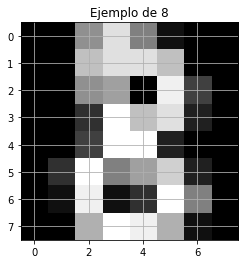

In [4]:
# Cargamos una muestra
plt.grid(True)
plt.title("Ejemplo de {}".format(y[8]))
plt.imshow(X[8, :].reshape((8, 8)), cmap='gray')

---

## Consignas

Siguiendo los ejemplos vistos en clase sobre los datasets de Human Activity Recognition y Fashion MNIST, realizar las siguientes consignas:

1. Aplicar PCA sobre el dataset para poder explicar el 90% de la varianza. ¿Cuántos componentes se requieren?
2. Graficar un scree plot (varianza contemplada en función del número de componentes considerados)
3. Visualizar gráficamente los primeros 5 componentes ¿Qué conclusiones se puede sacar de cada componente? [OPCIONAL].
4. Visualizar la imagen original vs. la reconstruida con los $m$ componentes del punto 1.
5. Graficar una matriz de correlación del dataset reducido.
6. Graficar los clusters de dígitos en 2 y 3 dimensiones usando los componentes obtenidos en PCA.
7. Aplicar K-means para clusterizar los dígitos ¿Cómo son los resultados?
8. Realizar un gráfico de inercia para obtener el número óptimo de clusters $k$.
9. Analizar visualmente los límites del cluster de algún dígito y "generar" artificialmente el dígito dándole valores a los primeros dos componentes de PCA.

### 1. Aplicar PCA

In [9]:
## Estandarizar 
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [54]:
## Aplicar PCA reteniendo componentes que tienen el 90% de la varianza
pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [55]:
# Cantidad de componentes necesarios
X_pca.shape[1]

18

### 2. Grafica de la varianza en función del num de componentes pca

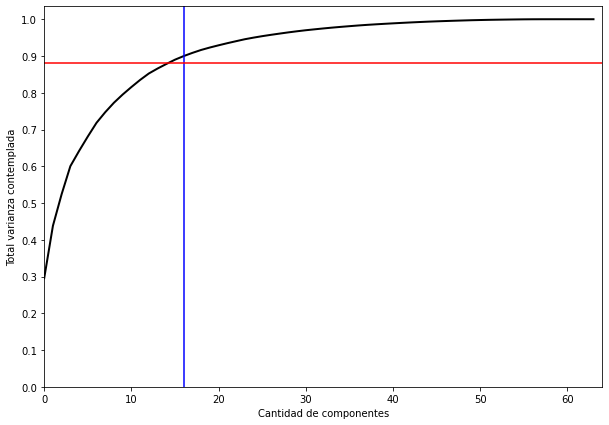

In [52]:
pca_2 = PCA(n_components=64, random_state=RANDOM_STATE).fit(X_scaled)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca_2.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Cantidad de componentes')
plt.ylabel('Total varianza contemplada')
plt.xlim(0, 64)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(18, c='b')
plt.axhline(0.9, c='r')
plt.show()

### 3. Visualizar los primeros 5 componentes

Primeras cinco componentes principales


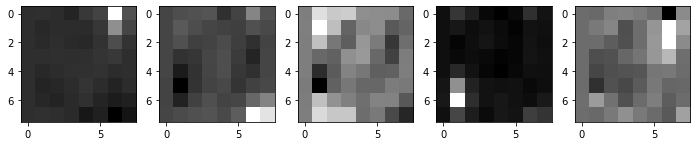

In [92]:
# Visualizar cuantiles de 5 componentes
print("Primeras cinco componentes principales")
n_comp = 5
fig, axs = plt.subplots(1, n_comp, figsize=(12, 12))
for i, ax in enumerate(axs):
    ax.imshow(pca.components_[i].reshape((8, 8)), cmap='gray')

### 4. Visualizar imagen original vs reconstruida con m componentes

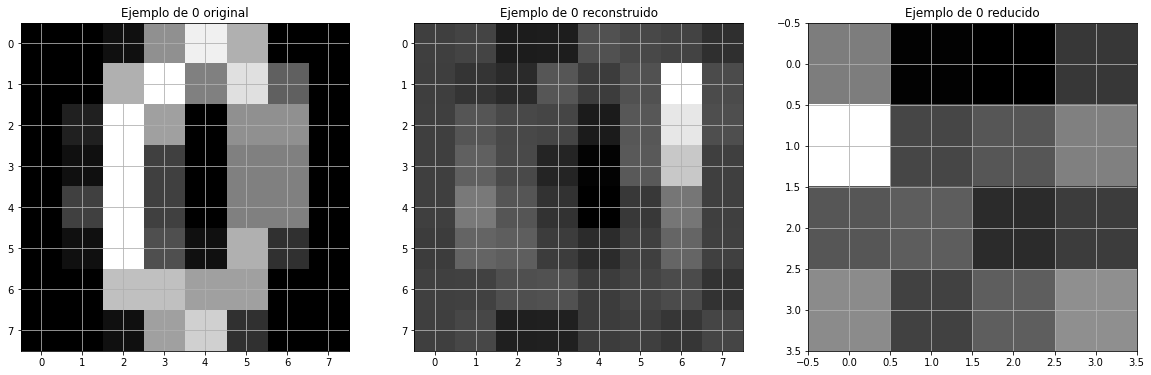

In [80]:
ex = 10
fig, axs = plt.subplots(1, 3, figsize=(20,20))
axs[0].set_title("Ejemplo de {} original".format(y[ex]))
axs[0].imshow(X[ex, :].reshape((8, 8)), cmap='gray')
axs[0].grid()

X_inv = pca.inverse_transform(X_pca[ex])
axs[1].set_title("Ejemplo de {} reconstruido".format(y[ex]))
axs[1].imshow(X_inv.reshape((8, 8)), cmap='gray')
axs[1].grid()

# Tomo 16 componentes (88% de la varianza) para poder graficar una imagen cuadrada
axs[2].set_title("Ejemplo de {} reducido".format(y[ex]))
axs[2].imshow(X_pca[ex, :16].reshape((4, 4)), cmap='gray')
axs[2].grid()

#fig.show();

### 5. Graficar matriz de correlación dataset reducido

In [90]:
corr_matrix = np.corrcoef(X_pca.T)
corr_matrix.shape

(18, 18)

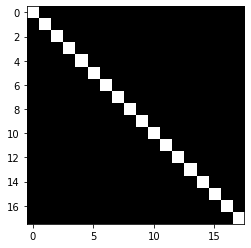

In [91]:
plt.imshow(corr_matrix, cmap="gray")

Cada una de las variables está descorrelacionada con el resto.

### 6. Graficar los clusters de dígitos en 2 y 3 dimensiones usando los componentes obtenidos en PCA.

Text(0.5, 1.0, 'PCA projection 2D')

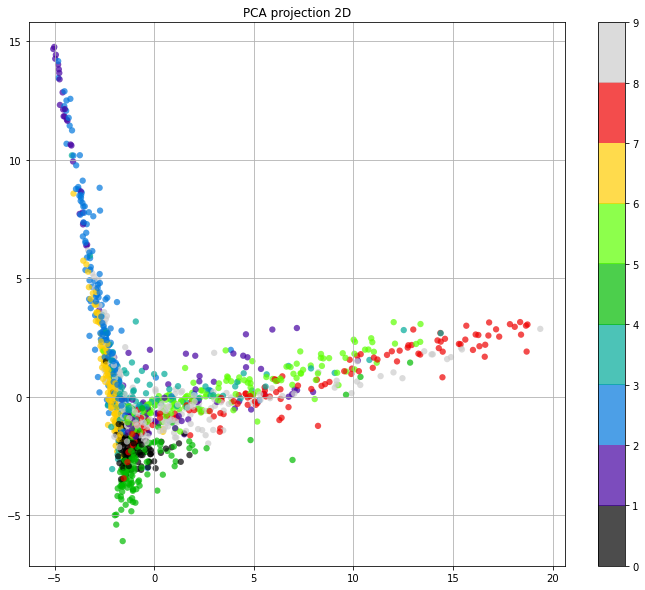

In [101]:
# Graficamos los primeros dos componentes
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', n_clases))
plt.colorbar()
plt.grid()
plt.title('PCA projection 2D')

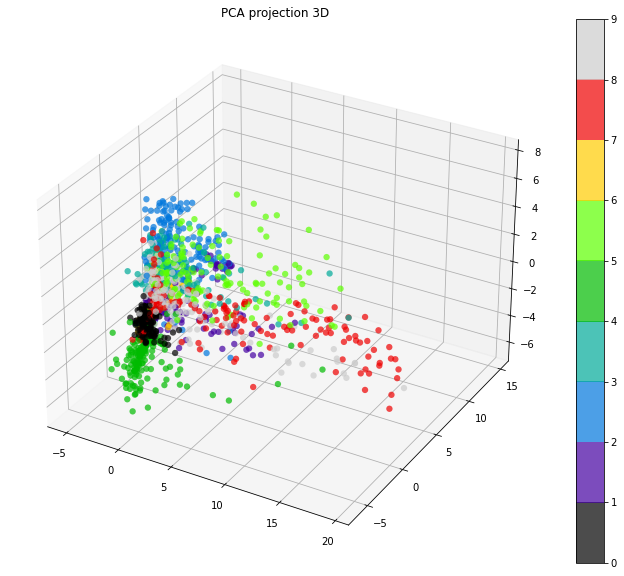

In [104]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],  c=y, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', n_clases))
#ax.colorbar()
ax.grid()
ax.set_title('PCA projection 3D')

fig.colorbar(p)

### 7. Aplicar K-means para clusterizar los dígitos ¿Cómo son los resultados?

In [108]:
kmeans = KMeans(n_clusters=n_clases, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

Text(0.5, 1.0, 'MNIST - PCA projection 2D')

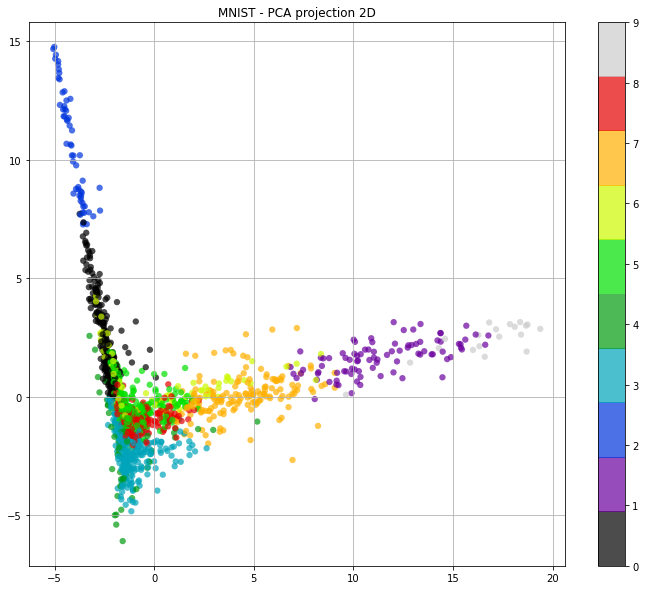

In [110]:
# Graficamos los primeros dos componentes - clusters id
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', n_clases))
plt.colorbar()
plt.grid()
plt.title('MNIST - PCA projection 2D')

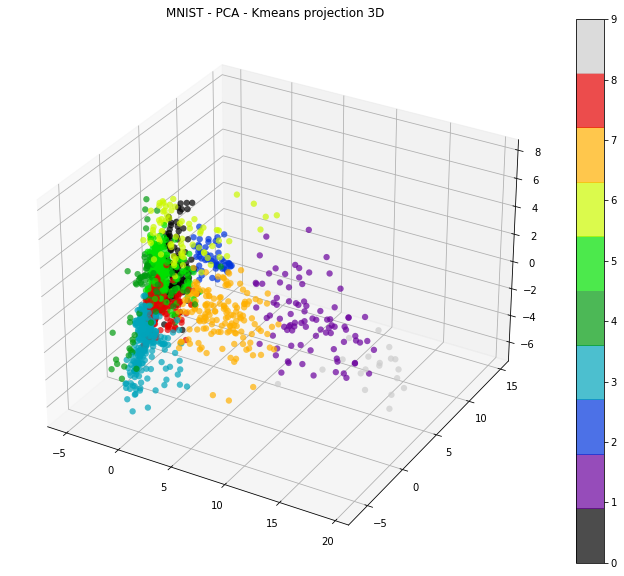

In [111]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],  c=cluster_labels, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', n_clases))
#ax.colorbar()
ax.grid()
plt.title('MNIST - PCA - Kmeans projection 3D')
fig.colorbar(p)

Los clusters no agrupan bien los dígitos

### 8. Realizar un gráfico de inercia para obtener el número óptimo de clusters $k$.

In [112]:
# Vemos la inercia (suma de las distancias de los miembros de un cluster a su centroide)
inertia = []
for k in range(1, n_clases + 1):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

$$\Large J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$

$C$ – es un set de clusters de orden $K$, $\mu_k$ es el centroide del cluster $C_k$.

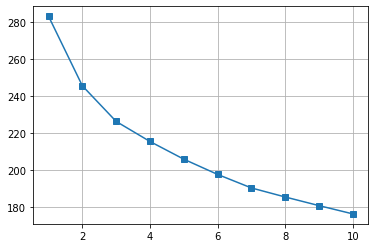

In [114]:
plt.plot(range(1, n_clases + 1), inertia, marker='s')
plt.grid()

$$\Large D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

In [120]:
d = {}
for k in range(2, n_clases):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])

In [126]:
print(d)
opt_num_clusters = min(d, key=d.get)
print(f"opt num of clusters: {opt_num_clusters}")

{2: 0.5119755266930546, 3: 0.5627154682708831, 4: 0.8829251294804549, 5: 0.8610027925113938, 6: 0.8872812407038689, 7: 0.6697087446611107, 8: 0.9522201174464586, 9: 0.9601490044657814}
opt num of clusters: 2


### 9. Analizar visualmente los límites del cluster de algún dígito y "generar" artificialmente el dígito dándole valores a los primeros dos componentes de PCA.

In [148]:
cluster_digit = 9
# Valor min-max primer componente
min_comp_0 = min(X_pca[cluster_labels==cluster_digit, 0])
max_comp_0 = max(X_pca[cluster_labels==cluster_digit, 0])
mid_comp_0 = (max_comp_0 + min_comp_0)/ 2
# Valor min-max segunda componente
min_comp_1 = min(X_pca[cluster_labels==cluster_digit, 1])
max_comp_1 = max(X_pca[cluster_labels==cluster_digit, 1])
mid_comp_1 = (max_comp_1 + min_comp_1)/ 2

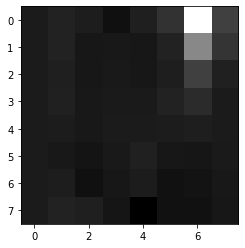

In [149]:
# Generar imagen
img_ = np.array([mid_comp_0, mid_comp_1]).dot(pca.components_[:2,:]) + pca.mean_
plt.imshow(img_.reshape((8, 8)), cmap='gray')

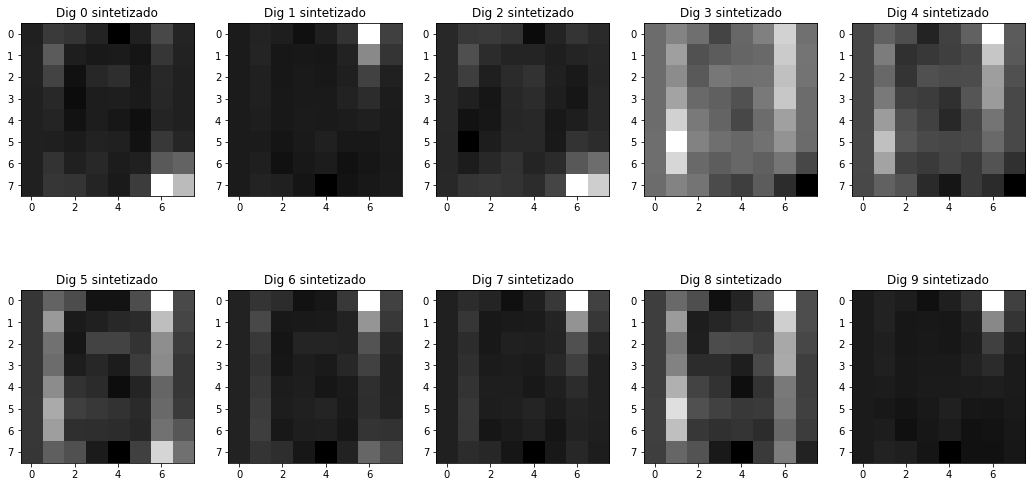

In [162]:
fig, axs = plt.subplots(2, 5, figsize=(18,9))
axs.shape    
for i in range(n_clases):
    row = int(i/5)
    column = i % 5

    # Valor min-max-mid primer componente
    min_comp_0 = min(X_pca[cluster_labels==i, 0])
    max_comp_0 = max(X_pca[cluster_labels==i, 0])
    mid_comp_0 = (max_comp_0 + min_comp_0)/2
    # Valor min-max-mid segunda componente
    min_comp_1 = min(X_pca[cluster_labels==i, 1])
    max_comp_1 = max(X_pca[cluster_labels==i, 1])
    mid_comp_1 = (max_comp_1 + min_comp_1)/2
    '''
    # Valor min-max-mid tercer componente
    min_comp_2 = min(X_pca[cluster_labels==i, 2])
    max_comp_2 = max(X_pca[cluster_labels==i, 2])
    mid_comp_2 = (max_comp_2 + min_comp_2)/2
    '''

    #img_ = np.array([mid_comp_0, mid_comp_1, mid_comp_2]).dot(pca.components_[:3,:]) + pca.mean_
    img_ = np.array([mid_comp_0, mid_comp_1]).dot(pca.components_[:2,:]) + pca.mean_

    axs[row, column].imshow(img_.reshape((8, 8)), cmap='gray')
    axs[row, column].set_title(f"Dig {i} sintetizado")
